## Small model to predict compute time from parameters of dense/convolutional layer

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.externals import joblib
import shutil

/home/peter/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/peter/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/peter/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/peter/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)  # To find local version of the library

In [3]:
from prediction_model.model import Model
from prediction_model import dataprep

### Import data as pd dataframe
#### Data should contain parameters and max/median/min/std of time

In [61]:
# model_name = 'all'
model_name = "QuadroP2000"
test_data  = "QuadroP2000"

MODEL_PATH = os.path.join(ROOT_DIR, 'prediction_model/models/%s/' %model_name)
DATA_PATH = os.path.join(ROOT_DIR, 'prediction_model/data')

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)
    print("Created {} directory".format(MODEL_PATH))

In [62]:
try:
    MODEL_PATH
except:
    pass 

useData = 'Conv' # 'Dense' or 'Conv'
# useData = 'Dense'

In [63]:
if useData == 'Conv':
    df = pd.read_pickle(os.path.join(DATA_PATH,'Data_convolution_%s.pkl' %model_name))
    scaler_filename = os.path.join(MODEL_PATH,'scaler_Conv.save')
elif useData == 'Dense':
    df = pd.read_pickle(os.path.join(DATA_PATH,'Data_dense_%s.pkl' %model_name))
    scaler_filename = os.path.join(MODEL_PATH,'scaler_Dense.save')
else:
    print('useData must be Dense or Conv, currently is %s' %useData)

In [64]:
datapath = os.path.join(DATA_PATH, "Data_convolution_{}.pkl".format(test_data))
print("Reading {} data from {}".format(model_name, datapath))
df_v100 = pd.read_pickle(datapath)
display(df_v100.head())
print(df_v100.columns)
print(sorted(df_v100['batchsize'].unique()))

Reading QuadroP2000 data from /HDD2/ML/ml-performance-prediction/prediction_model/data/Data_convolution_QuadroP2000.pkl


,batchsize,channels_in,channels_out,gpu,kernelsize,matsize,padding,precision,strides,timeUsed_max,...,opt_Adagrad,opt_Adam,opt_Momentum,opt_None,opt_RMSProp,opt_SGD,act_None,act_relu,act_sigmoid,act_tanh
0,174,3,1,0,3,455,0,32,3,287.358761,...,0,0,1,0,0,0,1,0,0,0
1,94,4,3,0,1,376,0,32,3,8.699989,...,0,0,0,1,0,0,0,0,1,0
2,247,2,4,0,2,339,1,32,4,10.870790,...,0,0,0,1,0,0,0,1,0,0
7,220,1,2,0,7,278,1,32,4,11.238384,...,0,0,0,1,0,0,1,0,0,0
8,82,2,2,0,2,280,0,32,3,5.150604,...,0,0,0,1,0,0,0,1,0,0


Index(['batchsize', 'channels_in', 'channels_out', 'gpu', 'kernelsize',
       'matsize', 'padding', 'precision', 'strides', 'timeUsed_max',
       'timeUsed_median', 'timeUsed_min', 'timeUsed_std', 'use_bias',
       'elements_matrix', 'elements_kernel', 'ops', 'memory_weights',
       'memory_in', 'memory_out', 'opt_Adadelta', 'opt_Adagrad', 'opt_Adam',
       'opt_Momentum', 'opt_None', 'opt_RMSProp', 'opt_SGD', 'act_None',
       'act_relu', 'act_sigmoid', 'act_tanh'],
      dtype='object')
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 12

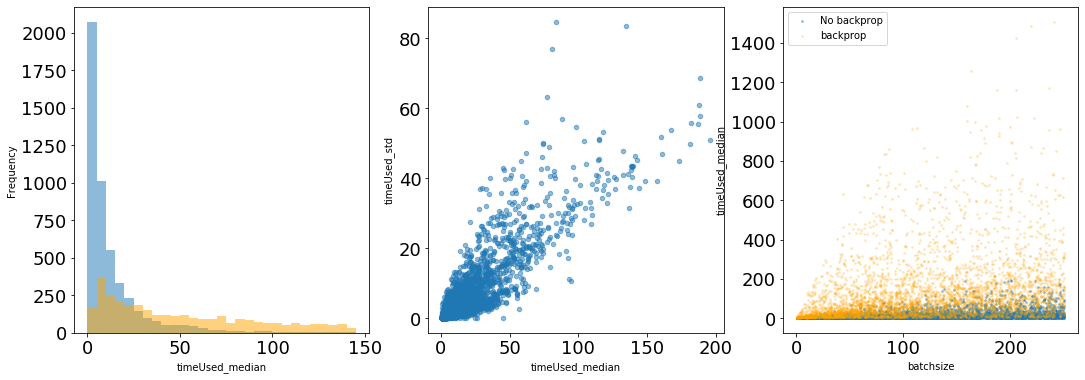

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[18,6])

df[df['opt_None']==1]['timeUsed_median'].plot.hist(bins=np.arange(0,150,5), ax=axes[0], alpha=.5)
df[df['opt_None']==0]['timeUsed_median'].plot.hist(bins=np.arange(0,150,5), ax=axes[0], alpha=.5, color='orange')
axes[0].set_xlabel("timeUsed_median")

df[df['opt_None']==1].plot.scatter(x='timeUsed_median', y='timeUsed_std', ax=axes[1], alpha=.5)

df[df['opt_None']==1].plot.scatter(x='batchsize', y='timeUsed_median', ax=axes[2], s=3, alpha=.4, label='No backprop')
df[df['opt_None']==0].plot.scatter(x='batchsize', y='timeUsed_median', ax=axes[2], s=3, alpha=.2, color='orange', label='backprop')

plt.show()

In [24]:
if useData == 'Dense':
    model_name = '%s_dense' %model_name

In [25]:
# # Only forward pass
# df = df[df['opt_SGD']==1]
# model_name = '%s_SGD'%model_name
# scaler_filename = ("scaler_%s_Conv.save" %model_name)

### Generate train, test and validation datasets (80%,10%,10%)
#### Normalise data, generate train, test, validation dataset
#### Use median of time as target parameter

In [26]:
print(model_name, useData)

QuadroP2000 Conv


In [27]:
split=[.8,.1,.1]
if model_name == 'all' or model_name[0:3] == 'no_':
    data_cols_conv = ['batchsize','elements_matrix','elements_kernel',
                      'channels_in','channels_out','padding','strides','use_bias', 
                      'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                      'act_relu','act_tanh','act_sigmoid',
                      'bandwidth','cores','clock']
    
    data_cols_dense = ['batchsize','dim_input','dim_output',
                       'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                       'act_relu','act_tanh','act_sigmoid',
                      'bandwidth','cores','clock']
    
else:
    data_cols_conv = ['batchsize','elements_matrix','elements_kernel',
                      'channels_in','channels_out','padding','strides','use_bias', 
                      'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                      'act_relu','act_tanh','act_sigmoid']
    
    data_cols_dense = ['batchsize','dim_input','dim_output',
                       'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                       'act_relu','act_tanh','act_sigmoid']


if useData == 'Conv':
    data_cols = data_cols_conv
elif useData == 'Dense':
    data_cols = data_cols_dense

In [28]:
data, time, train, test, validation, scaler = dataprep.data_preprocess(df,data_cols,split)
joblib.dump(scaler, scaler_filename) 

Size of train dataset: 7506 
Size of test dataset: 938 
Size of validation dataset: 939


['/HDD2/ML/ml-performance-prediction/prediction_model/models/QuadroP2000/scaler_Conv.save']

### Define model

In [29]:
if model_name == 'all' or model_name[0:3] == 'no_':
    num_neurons = [32,64,128,128,128,128]
else:
    num_neurons = [32,64,128,128]
    
lr_initial = 0.1
lr_decay_step = 40

In [30]:
tf.reset_default_graph()
data_dim = data['Train'].shape[1]

inputs = tf.placeholder(tf.float32, shape=(None, data_dim), name='model_input')
targets = tf.placeholder(tf.float32, shape=(None), name='model_targets')
learning_rate = tf.placeholder(tf.float32, shape=[])
reg_constant = .00001
dropout_rate = 0.2
batch_size = 128

#### Remove checkpoints and tb output

In [31]:
try:
    folder = './checkpoints/%s' % model_name
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        os.remove(file_path)

    folder = './graphs/prediction/test/%s' % model_name
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file) 
        os.remove(file_path)

    folder = './graphs/prediction/train/%s' % model_name
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file) 
        os.remove(file_path)
        
    print('Checkpoints cleared')
except:
    print('Nothing to delete')
    

Nothing to delete


In [32]:
model = Model(inputs,targets,learning_rate,reg_constant,dropout_rate,
              num_neurons,lr_initial,lr_decay_step,batch_size,model_name)

In [33]:
model.prediction
model.train_op


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dropout instead.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<tf.Operation 'Adam' type=AssignAdd>

### Run model, generate plots
##### Checkpoints in ./Checkpoint, tb graphs and summaries in ./graphs

In [34]:
model.train(data['Train'],time['Train'],data['Test'],time['Test'],300)

/HDD2/ML/ml-performance-prediction/prediction_model/notebooks






Epoch 0: Train loss 2.001, Test loss 0.583
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Epoch 10: Train loss 0.217, Test loss 0.207
Epoch 20: Train loss 0.187, Test loss 0.183
Epoch 30: Train loss 0.159, Test loss 0.169
Epoch 40: Train loss 0.110, Test loss 0.125
Epoch 50: Train loss 0.091, Test loss 0.115
Epoch 60: Train loss 0.085, Test loss 0.099
Epoch 70: Train loss 0.081, Test loss 0.098
Epoch 80: Train loss 0.063, Test loss 0.088
Epoch 90: Train loss 0.059, Test loss 0.082
Epoch 100: Train loss 0.057, Test loss 0.080
Epoch 110: Train loss 0.052, Test loss 0.079
Epoch 120: Train loss 0.047, Test loss 0.076
Epoch 130: Train loss 0.045, Test loss 0.072
Epoch 140: Train loss 0.044, Test loss 0.072
Epoch 150: Train loss 0.042, Test loss 0.070
Epoch 160: Train loss 0.041, Test loss 0.072
Epoch 170: Train loss 0.039, Test loss 0.069
Epoch 180: Train loss 0.039, Test loss 0.069
Epoc

In [35]:
saver = tf.train.Saver()
folder = os.path.join(ROOT_DIR, 'prediction_model/models/%s/saved_model' %model_name)
try:
    shutil.rmtree(folder)
except:
    pass
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/%s/checkpoint' %model_name))
    saver.restore(sess, ckpt.model_checkpoint_path)
    tf.saved_model.simple_save(
            sess,
            folder,
            inputs={'model_input': inputs,'model_istraining': model.istraining},
            outputs={'model_prediction': model.prediction})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints/QuadroP2000/prediction-299
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /HDD2/ML/ml-performance-prediction/prediction_model/models/QuadroP2000/saved_model/saved_model.pb


INFO:tensorflow:Restoring parameters from checkpoints/QuadroP2000/prediction-299


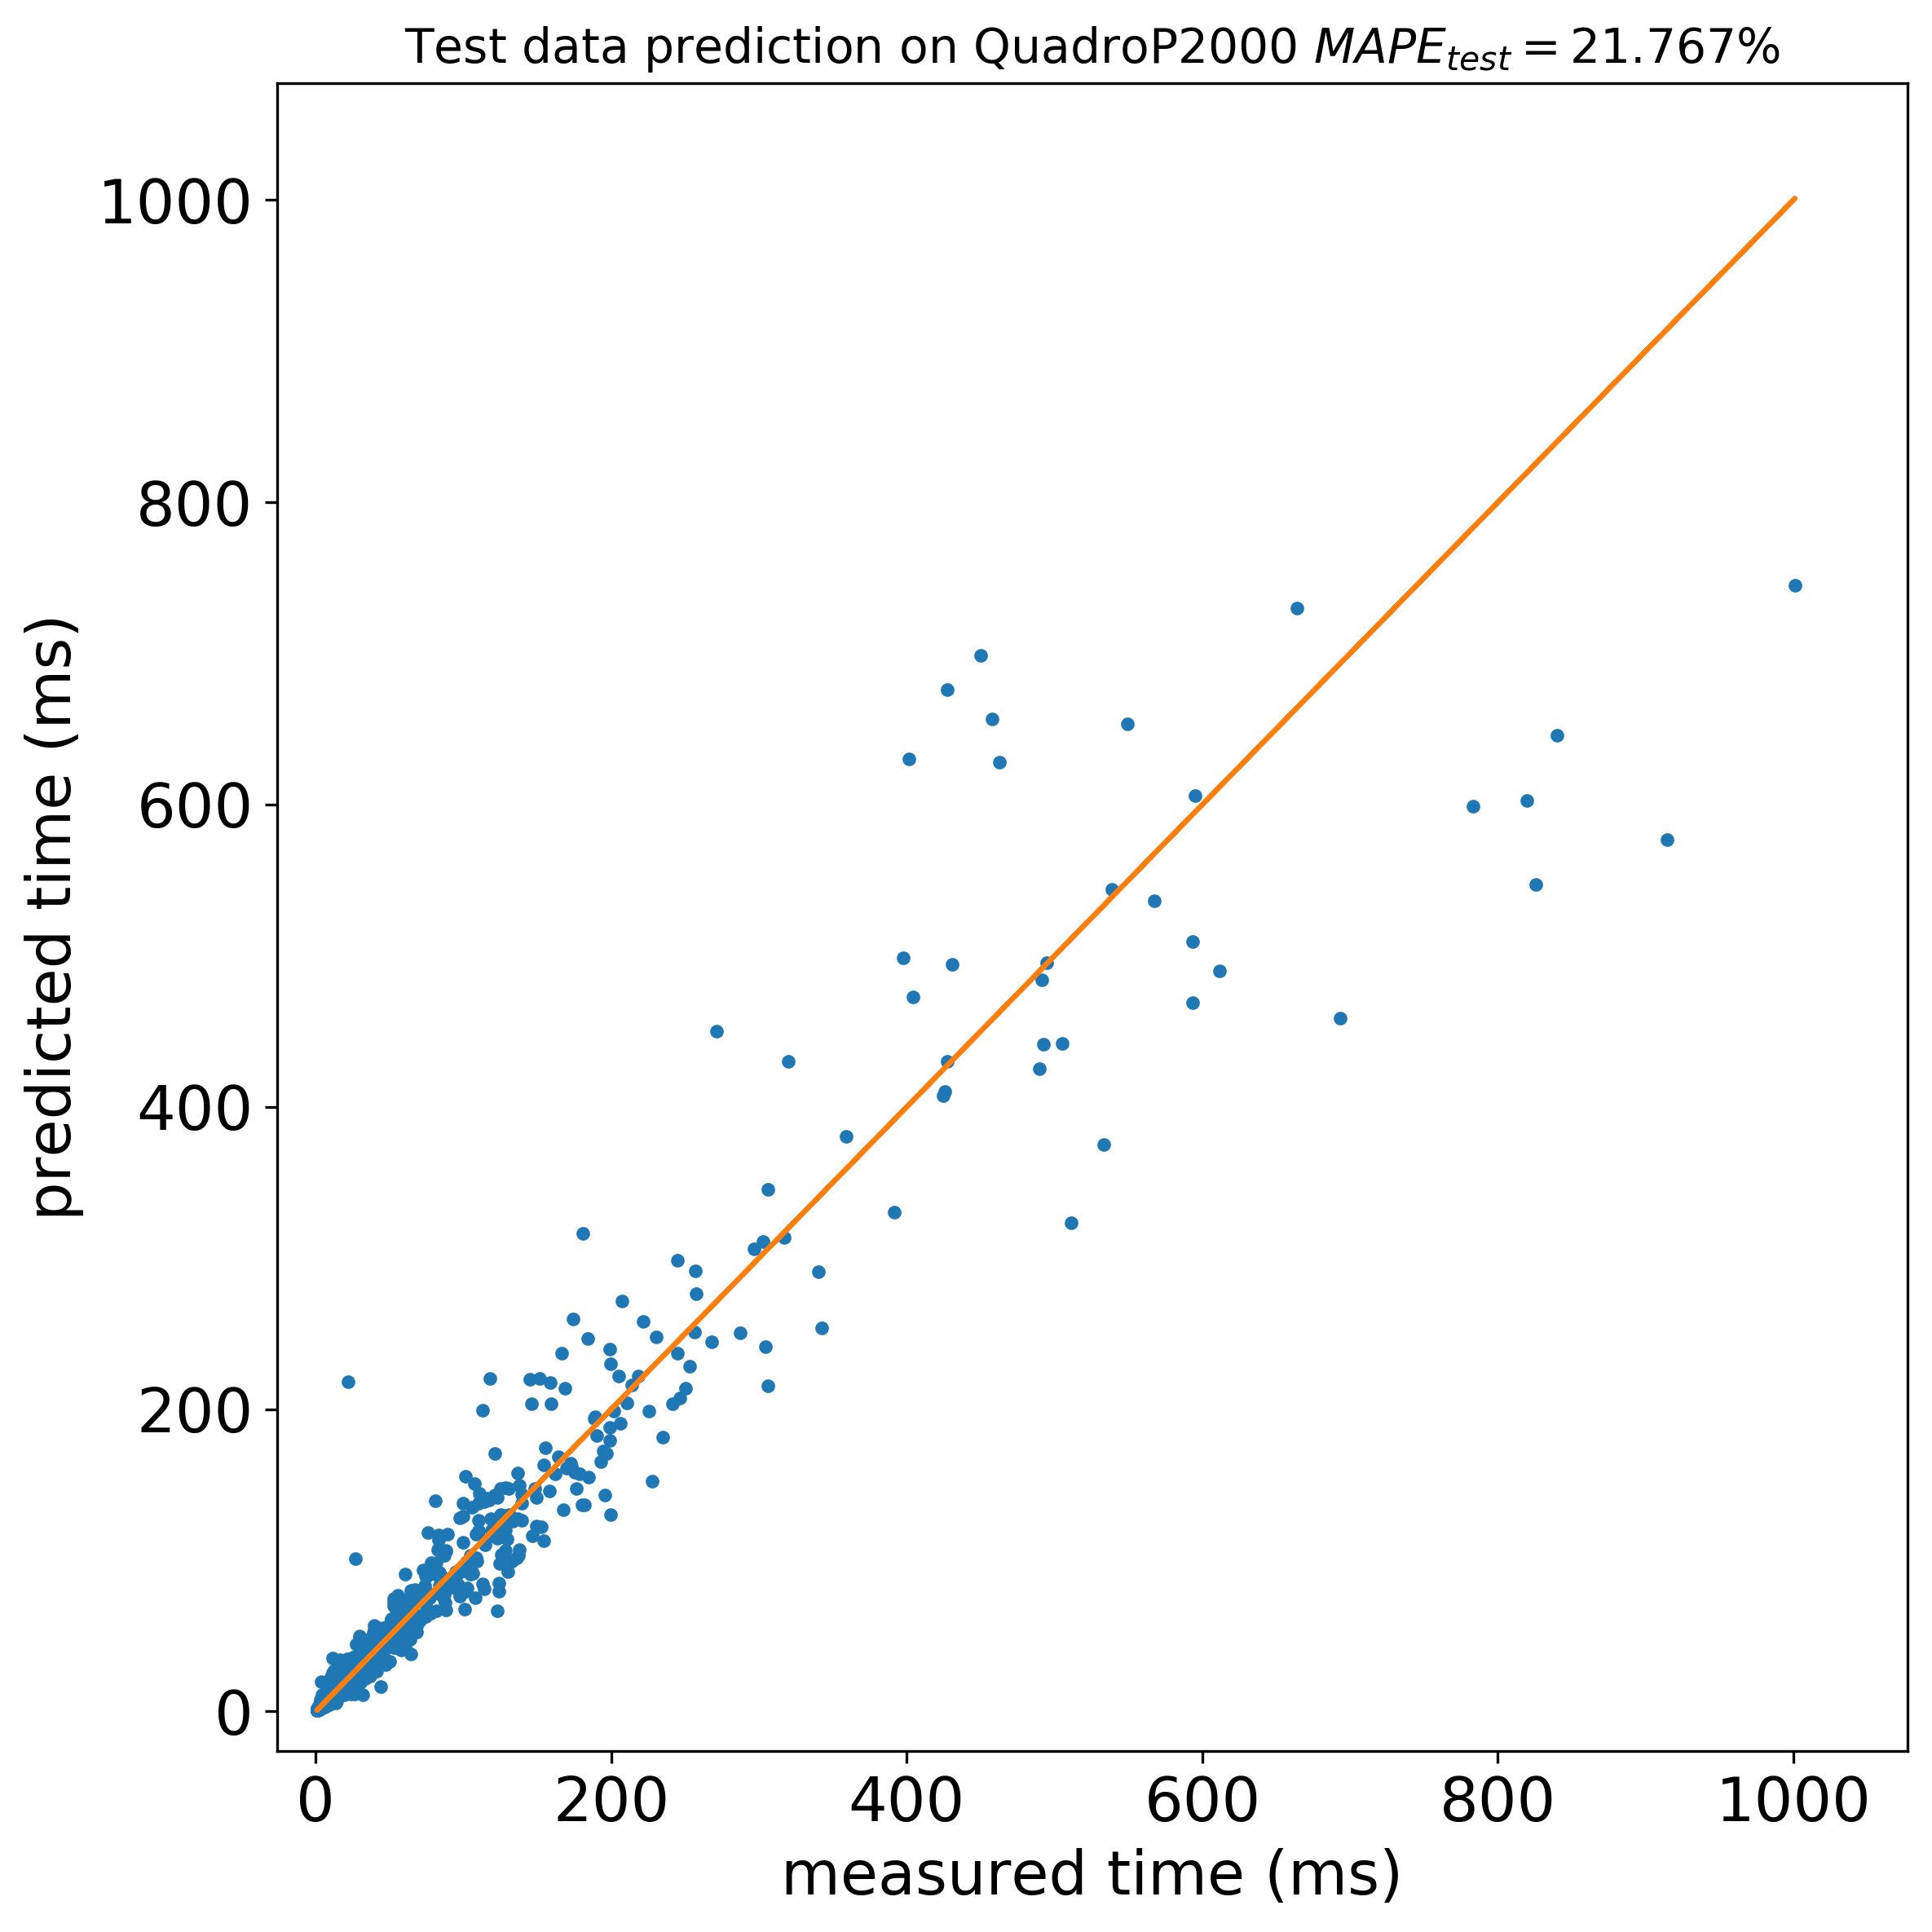

RMS test error = 34.8 ms


In [76]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    ckpt = tf.train.get_checkpoint_state(
        os.path.dirname('checkpoints/%s/checkpoint' % model_name))
    saver.restore(sess, ckpt.model_checkpoint_path)

    v = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))

    test_prediction, test_loss = sess.run(
        [model.prediction, model.loss],
        feed_dict={
            model.inputs: data['Test'],
            model.targets: time['Test'],
            model.istraining: False
        })

RMS_test_error = np.sqrt(np.mean((time['Test'] - test_prediction)**2))
MAPE_test = (np.abs(time['Test'] - test_prediction) / time["Test"]) * 100.

fig, ax = plt.subplots(1, 1, figsize=[8, 8],dpi=300)
ax.plot(time['Test'], test_prediction, '.')
ax.plot(time['Test'], time['Test'], 2)

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)

plt.xlabel('measured time (ms)', fontsize=18)
plt.ylabel('predicted time (ms)', fontsize=18)

axlim = max(plt.xlim()[1], plt.ylim()[1])

#plt.axis('equal')
ax.set_xlim(-axlim * .025, axlim * 1.025)
ax.set_ylim(-axlim * .025, axlim * 1.025)
ax.set_title(
    r'Test data prediction on {} $MAPE_{{test}} = {:.3f}\%$'.format(
        model_name, np.mean(MAPE_test)),
    fontsize=14)

plt.tight_layout()

# if useData == 'Conv':
#     plt.savefig('figures/Validation_%s_conv.png' %model_name, dpi=300)
# elif useData == 'Dense':
#     plt.savefig('figures/Validation_%s_fc.png' %model_name, dpi=300)

plt.show()
print('RMS test error = %.3g ms' % (RMS_test_error))

In [37]:
print(type(time["Test"]), type(test_prediction))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


### STOP here - validation data set

In [ ]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/%s/checkpoint' %model_name))
    saver.restore(sess, ckpt.model_checkpoint_path)
    
    v = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))
    
    validation_prediction, validation_loss = sess.run(
            [model.prediction,model.loss], 
            feed_dict={model.inputs: data['Validation'], 
                       model.targets: time['Validation'],
                       model.istraining: False}) 
    
RMS_validation_error=np.sqrt(np.mean((time['Validation']-validation_prediction)**2))
perc_error = np.mean(np.abs(time['Validation']-validation_prediction)/time['Validation'])*100

fig,ax = plt.subplots(1,1,figsize=[8,8])
ax.plot(time['Validation'],validation_prediction,'.')
ax.plot(time['Validation'],time['Validation'],2)


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

plt.xlabel('measured time (ms)',fontsize=30)
plt.ylabel('predicted time (ms)',fontsize=30)


axlim = max(plt.xlim()[1],plt.ylim()[1])


#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

# ax.xaxis.set_ticks([0,25,50,75,100,125])

plt.tight_layout()

# if useData == 'Conv':
#     plt.savefig('figures/Validation_%s_conv.png' %model_name, dpi=300)
# elif useData == 'Dense':
#     plt.savefig('figures/Validation_%s_fc.png' %model_name, dpi=300)

plt.show()
print('RMS validation error = %.3g ms' %(RMS_validation_error))
print('Percentage error = %.3g%%' %(perc_error))

## Build a linear regression as comparison

In [ ]:
df_validation = df.iloc[validation]
df_train = df.iloc[train]

In [ ]:
linreg = linear_model.LinearRegression()

In [ ]:
x_train = df_train[['batchsize','elements_matrix','elements_kernel',
                'channels_in','channels_out','padding','strides','use_bias','ops']].values   
y_train = df_train['timeUsed_median'].values   # time

x_valid = df_validation[['batchsize','elements_matrix','elements_kernel',
                'channels_in','channels_out','padding','strides','use_bias','ops']].values
y_valid = df_validation['timeUsed_median'].values   # time

In [ ]:
linreg.fit(x_train,y_train)

In [ ]:
lp = linreg.predict(x_valid)

In [ ]:
linreg.coef_

In [ ]:
labels = [.2,.3,.4,.5,1]

RMS_vadiation_error=np.sqrt(np.mean((y_valid-lp)**2))
perc_error = np.mean(np.abs(y_valid-lp)/y_valid)*100
fig,ax = plt.subplots(1,1,figsize=[8,8])

ax.plot(y_valid,lp,'.')

ax.plot(y_valid,y_valid)

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())


matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

plt.xlabel('measured time (ms)',fontsize=30)
plt.ylabel('predicted time (ms)',fontsize=30)

#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

# ax.xaxis.set_ticks([0,25,50,75,100,125])

plt.tight_layout()


# if useData == 'Conv':
#     plt.savefig('figures/Validation_%s_conv_linearreg.png' %model_name, dpi=300)
# elif useData == 'Dense':
#     plt.savefig('figures/Validation_%s_fc_linearreg.png' %model_name, dpi=300)

plt.show()

In [ ]:
RMS_vadiation_error

In [ ]:
perc_error